<h1>About the A/B Test</h1>
The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Your goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

### Data Features
- **user_id** → Unique identifier for each user  
- **timestamp** → Time of visit  
- **group** → Indicates whether the user was in the control or treatment group  
- **landing_page** → The version of the page the user saw (new or old)  
- **converted** → Whether the user converted (`1 = Yes`, `0 = No`)  

### Experiment Design
- **Control Group** → Users who saw the old landing page  
- **Treatment Group** → Users who saw the new landing page  

### Goal
The objective is to determine whether the company should:  
1. Implement the new page  
2. Keep the old page  
3. Run the experiment longer before making a decision

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ab_data.csv')
df_countries = pd.read_csv('countries.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [5]:
df = pd.merge(df_countries,df, on='user_id', how='inner')
df.head()

,user_id,country,timestamp,group,landing_page,converted
0,834778,UK,08:43.3,control,old_page,0
1,928468,US,44:16.4,treatment,new_page,0
2,822059,UK,04:14.7,treatment,new_page,1
3,711597,UK,14:24.8,control,old_page,0
4,710616,UK,14:44.0,treatment,new_page,0


### Dealing with Duplicate Variables
To ensure data integrity, I kept only the first occurrence of each user_id, removing any duplicate entries.

In [6]:
print(f"Duplicate user IDs: {df.duplicated(subset=['user_id']).sum()}")

Duplicate user IDs: 3897


In [7]:
# Remove duplicate user_id entries (keeping the first occurrence)
df = df.drop_duplicates(subset=['user_id'],keep='first')

# Verify if duplicates remain
print(f"Duplicate user IDs after cleaning: {df.duplicated(subset=['user_id']).sum()}")

Duplicate user IDs after cleaning: 0


In [8]:
mismatch = df[(df['group'] == 'control') & (df['landing_page'] != 'old_page') | 
              (df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]
print(f"Number of mismatched entries: {len(mismatch)}")

print("\nMissing Values:")
#check for missing values
print(df.isnull().sum())

Number of mismatched entries: 2044

Missing Values:
user_id         0
country         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [9]:
mismatch.head()

,user_id,country,timestamp,group,landing_page,converted
102,842181,US,29:39.0,treatment,old_page,0
422,942678,US,37:44.6,treatment,old_page,0
618,795558,CA,11:06.6,control,new_page,1
664,886346,US,53:13.1,control,new_page,0
783,886323,UK,23:13.4,control,new_page,0


#### There are 2,044 mismatched entries, meaning:
- Some users in control saw the new_page.
- Some users in treatment saw the old_page.

In [10]:
# Remove rows where group and landing_page don't match
df_cleaned = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
                ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

# Verify if mismatches remain
mismatches_after = df_cleaned[((df_cleaned['group'] == 'control') & (df_cleaned['landing_page'] != 'old_page')) |
                              ((df_cleaned['group'] == 'treatment') & (df_cleaned['landing_page'] != 'new_page'))]

print(f"Number of mismatched entries after cleaning: {len(mismatches_after)}")

Number of mismatched entries after cleaning: 0


In [11]:
df_cleaned.head()

,user_id,country,timestamp,group,landing_page,converted
0,834778,UK,08:43.3,control,old_page,0
1,928468,US,44:16.4,treatment,new_page,0
2,822059,UK,04:14.7,treatment,new_page,1
3,711597,UK,14:24.8,control,old_page,0
4,710616,UK,14:44.0,treatment,new_page,0


#### Addressing Timestamp
The dataset contains information from the **first 60 minutes** of operation.

In [12]:
df_cleaned['minutes'] = df_cleaned['timestamp'].str.split(':').str[0].astype(int)
df_cleaned['seconds'] = df_cleaned['timestamp'].str.split(':').str[1].astype(float)

In [13]:
#compute total seconds
df_cleaned['total_seconds'] = df_cleaned['minutes'] * 60 + df_cleaned['seconds']

#Display the first few rows to verify
df_cleaned[['timestamp','minutes','seconds','total_seconds']].head()

,timestamp,minutes,seconds,total_seconds
0,08:43.3,8,43.3,523.3
1,44:16.4,44,16.4,2656.4
2,04:14.7,4,14.7,254.7
3,14:24.8,14,24.8,864.8
4,14:44.0,14,44.0,884.0


Visualizing Country as a factor

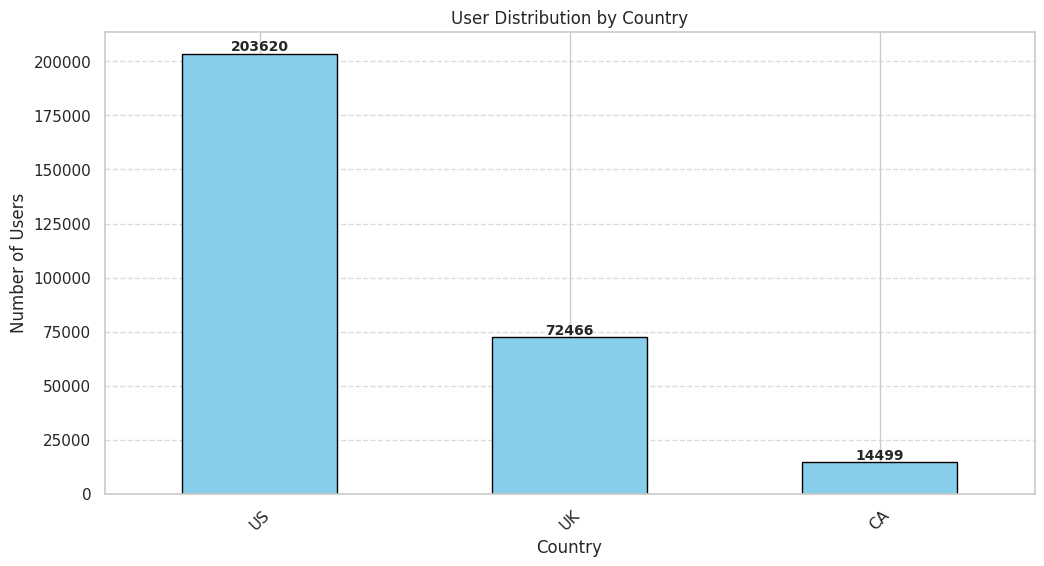

In [14]:
# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))
ax = df['country'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title("User Distribution by Country")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Add value labels
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),                # Value
        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.show()

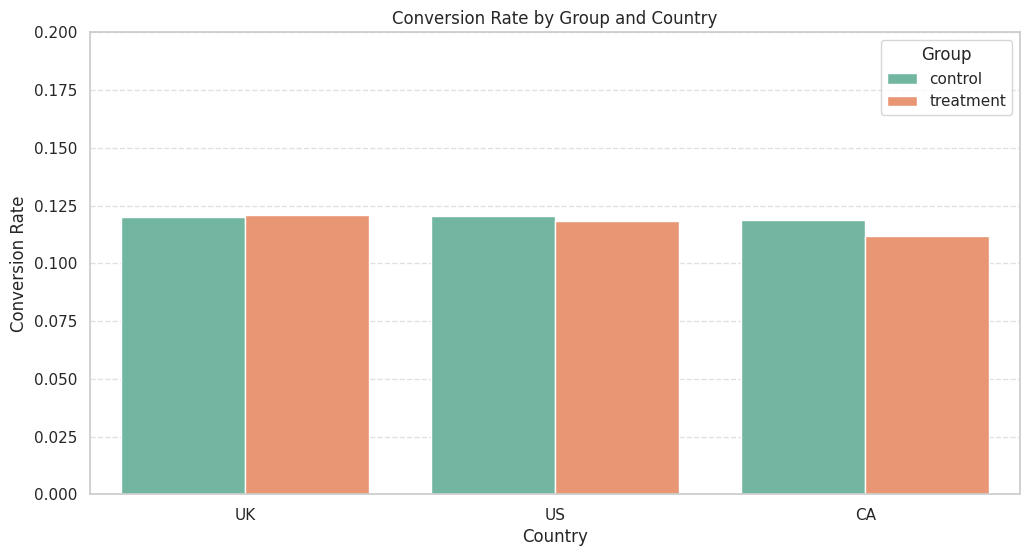

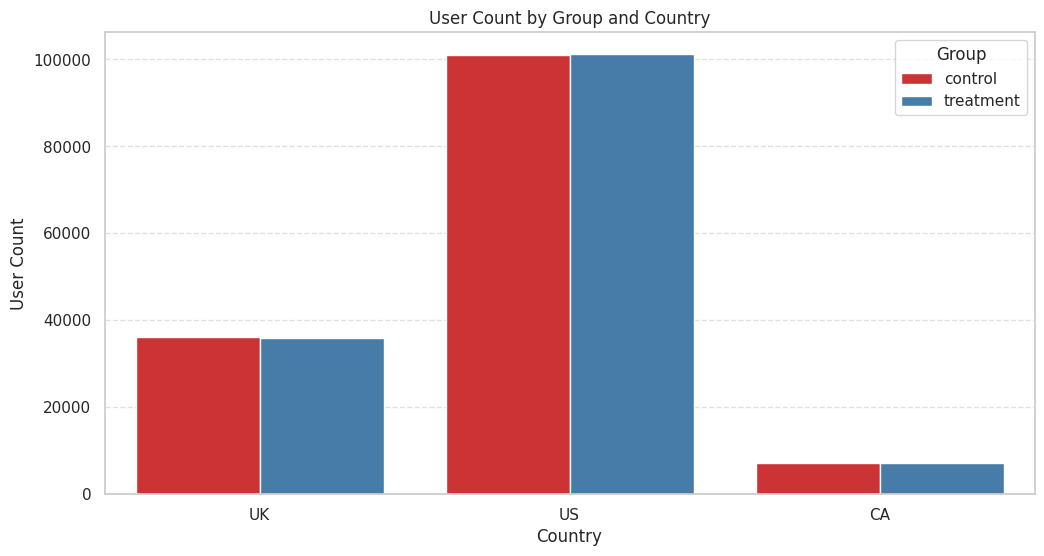

In [15]:
# Set style
sns.set(style="whitegrid")

# Chart 1: Conversion Rate by Group and Country
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_cleaned,
    x='country',
    y='converted',
    hue='group',
    estimator=lambda x: sum(x)/len(x),
    ci=None,
    palette='Set2'
)
plt.title("Conversion Rate by Group and Country")
plt.ylabel("Conversion Rate")
plt.xlabel("Country")
plt.ylim(0, 0.2)
plt.legend(title="Group")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Chart 2: User Count by Group and Country
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_cleaned,
    x='country',
    hue='group',
    palette='Set1'
)
plt.title("User Count by Group and Country")
plt.ylabel("User Count")
plt.xlabel("Country")
plt.legend(title="Group")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Statistical Analysis
The following methods were used to evaluate the experiment's results:

- **Conversion Rates** → Compare the proportion of users who converted in each group
- **Welch’s T-Test** → Assess if there is a significant difference in conversion rates
- **Chi-Square Test** → Evaluate whether conversions are independent of the landing page version

In [16]:
conversion_rates = df_cleaned.groupby(by='group')['converted'].agg(['mean','count'])
conversion_rates.rename(columns={'mean':'conversion_rate'},inplace=True)

conversion_rates

,conversion_rate,count
group,,
control,0.120290,144226
treatment,0.118726,144315


### Results
The **control group (old page)** had a **slightly higher conversion rate** than the **treatment group (new page)**. However, the difference is **very small.**

At first glance, it may seem that the **old page is performing slightly better**, but we need **statistical tests** to determine whether this difference is **significant** or just **random noise**.


## T-Test
- The **T-Test** checks whether the observed difference in conversion rates is **statistically significant** or just due to **random variation.**
- The **p-value** tells us how likely we are to see this difference if the **null hypothesis (H₀)** were true.
- This means we expect the new page to **either perform better or worse** than the old page, depending on the results.

In [17]:
from scipy.stats import ttest_ind

# Extract conversion values for each group
control = df_cleaned[df_cleaned['group'] == 'control']['converted']
treatment = df_cleaned[df_cleaned['group'] == 'treatment']['converted']

# Perform Welch’s T-test (unequal variances)
t_stat, p_ttest = ttest_ind(control, treatment, equal_var=False)
print(f"T-Test p-value: {p_ttest:.4f}")

if p_ttest < 0.05:
    print("The new page has a significant impact on conversion rate.")
else:
    print("The new page does NOT have a significant impact on conversion rate.")

T-Test p-value: 0.1953
The new page does NOT have a significant impact on conversion rate.


### Results
If **p < 0.05**, we reject H₀ (meaning the new page significantly affects conversion).
Since **p = 0.1953 > 0.05**, we **fail to reject H₀**.

#### Interpretation:
✅ p < alpha → Reject H₀ → The new page **significantly impacts** conversions.<br>
❌ p > alpha → Fail to reject H₀ → **No strong evidence** that the new page is different.

#### Conclusion:
The **new page does NOT significantly improve conversion rates.**

## Chi-Square Test
The **Chi-Square Test compares categorical data** (converted = 0 or 1) between the **control** and **treatment** groups to determine if there is a **statistically significant difference.**

In [38]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['group'], df_cleaned['converted'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test p-value: {p:.4f}")

if p < 0.05:
    print("The difference in conversion rates is statistically significant.")
else:
    print("No significant difference in conversion rates.")

Chi-Square Test p-value: 0.1973
No significant difference in conversion rates.


In [39]:
contingency_table

converted,0,1
group,,
control,126877,17349
treatment,127181,17134


**Time Approach: Does Time of Visit Affect Conversions?** <br>
We analyze whether the **time of visi**t has an impact on conversion rates. By segmenting the data into **time bins**, we can assess if conversions vary over time and whether this influences the effectiveness of the landing page.

In [19]:
# Define bin edges (0 to 3600 seconds, in 10-minute intervals)
bins = np.arange(0, 3600 + 600, 600)  # Bins: [0-600], [600-1200], etc.

# Create labels for bins
labels = [f"{int(bins[i]//60)}-{int(bins[i+1]//60)} min" for i in range(len(bins)-1)]

# Categorize total seconds into bins
df_cleaned['time_bin'] = pd.cut(df_cleaned['total_seconds'], bins=bins, labels=labels, include_lowest=True)

# Check binning result
df_cleaned[['total_seconds', 'time_bin']].head()

,total_seconds,time_bin
0,523.3,0-10 min
1,2656.4,40-50 min
2,254.7,0-10 min
3,864.8,10-20 min
4,884.0,10-20 min


In [20]:
# Group by time_bin and group (control/treatment) to calculate conversion rates
time_conversion = df_cleaned.groupby(by=['time_bin','group'])['converted'].mean().reset_index()

# Rename columns for clarity
time_conversion.columns = ['Time Interval', 'Group', 'Conversion Rate']

# Display result
time_conversion

,Time Interval,Group,Conversion Rate
0,0-10 min,control,0.121880
1,0-10 min,treatment,0.118130
2,10-20 min,control,0.120246
3,10-20 min,treatment,0.115934
4,20-30 min,control,0.120906
5,20-30 min,treatment,0.119279
6,30-40 min,control,0.119359
7,30-40 min,treatment,0.123001
8,40-50 min,control,0.119389
9,40-50 min,treatment,0.119192


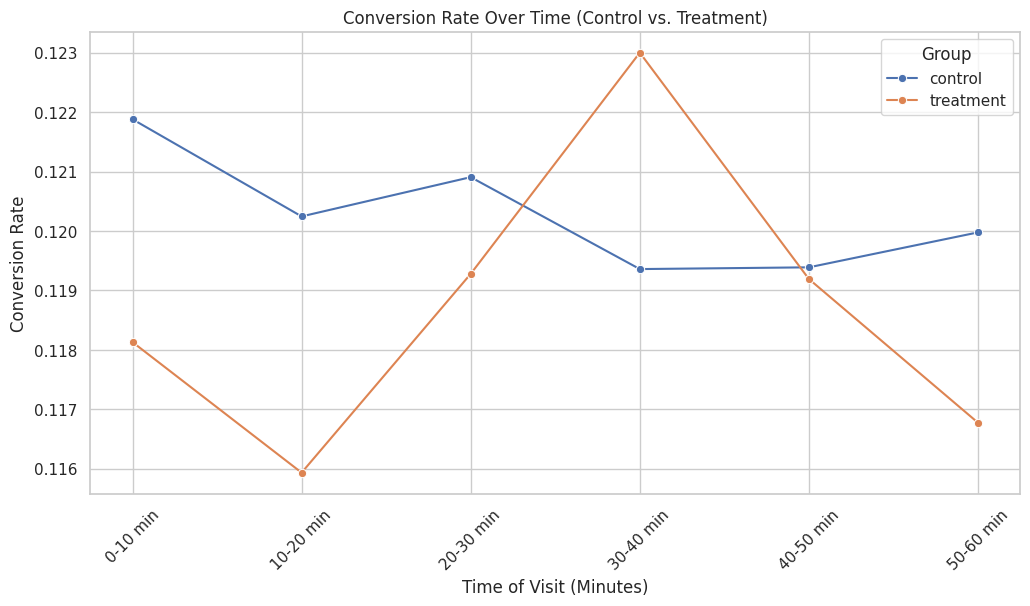

In [25]:
# Plot conversion rate over time for both groups
plt.figure(figsize=(12, 6))
sns.lineplot(x='Time Interval', y='Conversion Rate', hue='Group', marker='o', data=time_conversion)

# Customize the plot
plt.xticks(rotation=45)
plt.xlabel("Time of Visit (Minutes)")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate Over Time (Control vs. Treatment)")
plt.legend(title="Group")
plt.grid(True)

# Show the plot
plt.show()

#### Expected Insights
- If the **treatment group** has consistently higher conversion rates → The new page might **perform better** at certain times.
- If both lines **overlap** → The **time of visit** doesn't affect conversion rates.
- If the **control group** has higher conversion rates → The **old page** outperforms the new page at certain times.

### Chi-Square Test
The Chi-Square Test compares categorical data (converted = 0 or 1) between the control and treatment groups to assess if there is a statistically significant difference in conversions.

In [26]:
from scipy.stats import chi2_contingency

# Create a contingency table: counts of converted and not converted per time bin
contingency_table = pd.crosstab(df_cleaned['time_bin'], df_cleaned['converted'])

# Perform Chi-Square Test
chi2, p_chi, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Test p-value: {p_chi:.4f}")

if p_chi < 0.05:
    print("Time of visit has a significant impact on conversion rate.")
else:
    print("No significant difference in conversion rates based on time of visit.")

Chi-Square Test p-value: 0.6902
No significant difference in conversion rates based on time of visit.


### Confidence Interval (CI) for Conversion Rates
We calculated the Confidence Interval (CI) for the conversion rates across different time bins, comparing the control and treatment groups. The CI provides a range within which we expect the true conversion rate to fall, giving us an indication of the uncertainty around the estimated conversion rates for each group.

The time conversion rate is analyzed by group, showing how conversions differ over time for the old and new landing pages.

In [29]:
import scipy.stats as st

# Function to calculate CI for conversion rates
def conversion_CI(conversion_rate, n, confidence=0.95):
    se = (conversion_rate * (1 - conversion_rate) / n) ** 0.5  # Standard Error
    margin = st.norm.ppf((1 + confidence) / 2) * se  # Margin of Error
    return (conversion_rate - margin, conversion_rate + margin)

# Compute CIs for each time bin and group
time_conversion['CI_Lower'] = time_conversion.apply(
    lambda row: conversion_CI(row['Conversion Rate'], 
                              df_cleaned[(df_cleaned['time_bin'] == row['Time Interval']) & 
                                         (df_cleaned['group'] == row['Group'])].shape[0])[0], axis=1)

time_conversion['CI_Upper'] = time_conversion.apply(
    lambda row: conversion_CI(row['Conversion Rate'], 
                              df_cleaned[(df_cleaned['time_bin'] == row['Time Interval']) & 
                                         (df_cleaned['group'] == row['Group'])].shape[0])[1], axis=1)

# Display result
time_conversion

,Time Interval,Group,Conversion Rate,CI_Lower,CI_Upper
0,0-10 min,control,0.121880,0.117721,0.126040
1,0-10 min,treatment,0.118130,0.114056,0.122204
2,10-20 min,control,0.120246,0.116126,0.124365
3,10-20 min,treatment,0.115934,0.111868,0.119999
4,20-30 min,control,0.120906,0.116805,0.125007
5,20-30 min,treatment,0.119279,0.115185,0.123373
6,30-40 min,control,0.119359,0.115256,0.123463
7,30-40 min,treatment,0.123001,0.118858,0.127144
8,40-50 min,control,0.119389,0.115299,0.123478
9,40-50 min,treatment,0.119192,0.115108,0.123277


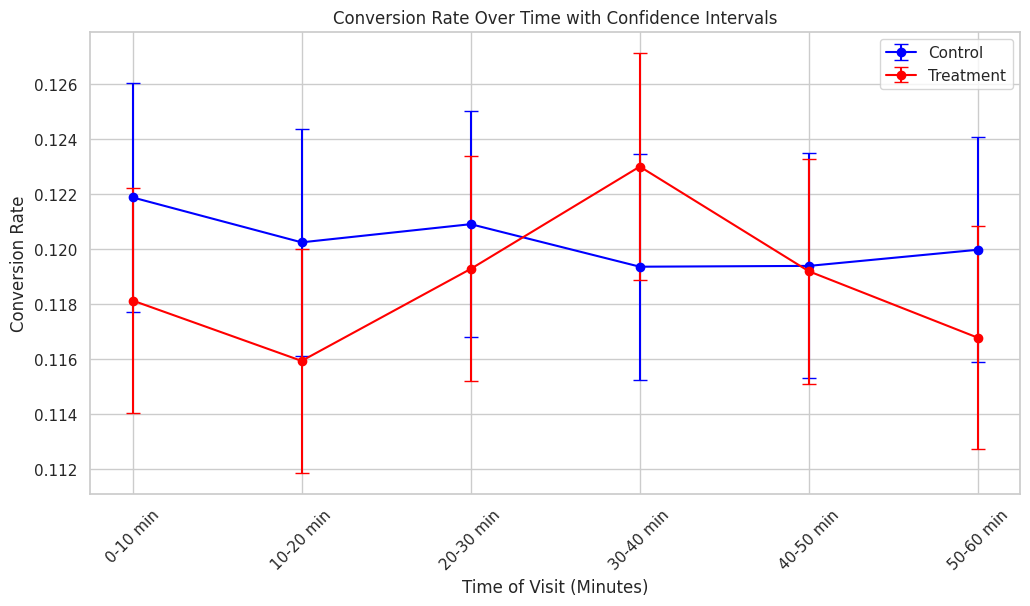

In [33]:
# Plot conversion rate with error bars (Confidence Intervals)
plt.figure(figsize=(12, 6))

# Plot Control group
plt.errorbar(time_conversion[time_conversion['Group'] == 'control']['Time Interval'], 
             time_conversion[time_conversion['Group'] == 'control']['Conversion Rate'], 
             yerr=[time_conversion[time_conversion['Group'] == 'control']['Conversion Rate'] - time_conversion[time_conversion['Group'] == 'control']['CI_Lower'],
                   time_conversion[time_conversion['Group'] == 'control']['CI_Upper'] - time_conversion[time_conversion['Group'] == 'control']['Conversion Rate']],
             fmt='o-', capsize=5, label="Control", color='blue')

# Plot Treatment group
plt.errorbar(time_conversion[time_conversion['Group'] == 'treatment']['Time Interval'], 
             time_conversion[time_conversion['Group'] == 'treatment']['Conversion Rate'], 
             yerr=[time_conversion[time_conversion['Group'] == 'treatment']['Conversion Rate'] - time_conversion[time_conversion['Group'] == 'treatment']['CI_Lower'],
                   time_conversion[time_conversion['Group'] == 'treatment']['CI_Upper'] - time_conversion[time_conversion['Group'] == 'treatment']['Conversion Rate']],
             fmt='o-', capsize=5, label="Treatment", color='red')

# Chart labels and title
plt.xticks(rotation=45)
plt.xlabel("Time of Visit (Minutes)")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate Over Time with Confidence Intervals")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### *Results*

- The control and treatment confidence intervals (CIs) overlap in **all time bins**.
- **Example (0-10 min bin):**
  - **Control:** [0.1177, 0.1260]  
  - **Treatment:** [0.1141, 0.1222]  
- Since the intervals overlap, this suggests **no strong evidence that time significantly impacts conversion rates.**

#### *Slight Differences in Some Bins*
- **30-40 min bin:**
  - Treatment: (0.1189 – 0.1271)  
  - Control: (0.1153 – 0.1235)  
  - Slight difference, but overlap still exists.

- **50-60 min bin:**
  - Control: (0.1159 – 0.1241)  
  - Treatment: (0.1127 – 0.1208)  
  - Slight gap, but overlap still present.


### **Conclusion**
- Since the CIs overlap, the conversion rates by time **do not show strong differences**.  
- This suggests that **time of visit does NOT significantly impact conversions**.
- Let's **confirm this statistically** with **Power Analysis**

#### Power Analysis
- Did we collect enough data to detect a real difference?
- If there was a real difference, what’s the risk that we missed it? (Type II Error)
- What’s the minimum effect size (Delta, Δ) we can detect?

In [35]:
time_conversion.groupby(by='Group')['Conversion Rate'].mean()

Group
control      0.120293
treatment    0.118718
Name: Conversion Rate, dtype: float64

In [36]:
from statsmodels.stats.power import TTestIndPower

# Define parameters
alpha = 0.05  # Significance level (5%)
power = 0.8   # Desired power (80%)

# Compute effect size (Cohen's d)
effect_size = (0.1203 - 0.1187) / ((0.1203 * (1 - 0.1203) + 0.1187 * (1 - 0.1187)) / 2) ** 0.5

# Run power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

print(f"Required Sample Size per Group: {round(sample_size)}")

Required Sample Size per Group: 645196


#### Results
- To reliably detect a meaningful difference between the old and new page, we would need at least 645,196 users per group (total ~1.29 million users).
- However, our actual sample size was only ~144,000 users per group (far less than needed).

#### Type II Error (β)
A Type II Error (β) occurs when we fail to detect a true effect (false negative). This means that even if there is a real difference, we may incorrectly conclude that no difference exists due to the insufficient sample size or other factors.

In [37]:
# Compute achieved power with our actual sample size
actual_power = analysis.power(effect_size=effect_size, nobs1=144000, alpha=0.05, alternative='two-sided')

print(f"Achieved Power: {actual_power:.4f}")

Achieved Power: 0.2628


#### Power Analysis Results
- Power > 0.8 → We have enough data to detect a real difference.
- Power < 0.8 → We may not have collected enough data, increasing the risk of a Type II error (β).<br>

Ideally, Power ≥ 0.80 (80%) is required to detect a true difference if one exists.

- Our achieved power is only 26.3%, meaning there’s a high chance (~73.7%) that we failed to detect a real difference (Type II error).
- In other words, even if the new page was better, our test was too weak to prove it.

#### Why Was Power So Low?
1. Small Effect Size (Δ)
- The difference between the control (0.1203) and treatment conversion rates (0.1187) is very tiny.
- Small differences require much larger sample sizes to be statistically detectable.

2. Not Enough Data
- We only had ~144K users per group, but we needed ~645K per group.
- This means the test lacked the statistical strength to confirm a real effect.

3. High Type II Error (β ≈ 73.7%)
- A Type II error occurs when we fail to reject the null hypothesis when there is actually an effect.
- Since β = 1 - power, a power of 0.2628 means a 73.7% chance of missing a true effect.

### Conclusion
If making a decision now, the safest choice is to keep the old page since we have no strong evidence that the new page is better.